# Filter Motive targets by PHH expression

PHH counts are from this paper: https://www.nature.com/articles/s42003-022-04046-9 and were downloaded from this github repo: https://github.com/iardisasmita/HLCompR/tree/main/shiny_app

In [1]:
import polars as pl
from pybiomart import Dataset

In [2]:
counts = pl.read_csv("../1_snakemake/inputs/rnaseq/PHH_counts.csv")
counts_ens = counts.select("ensmbl_gene_name").to_series().to_list()
counts_ens = [i.split(".")[0] for i in counts_ens]

In [3]:
# Get gene symbols in Motive
motive_symbols = pl.read_parquet("../1_snakemake/outputs/dino/mad_featselect/classifier_results/motive_binary_predictions.parquet").select("Metadata_Label").to_series().unique().to_list()
motive_symbols = [i.split("_")[0] for i in motive_symbols]
motive_symbols = list(set(motive_symbols))

In [4]:
# Mapping between gene symbol and ENSGID 
dataset = Dataset(name='hsapiens_gene_ensembl', host='http://www.ensembl.org')
gene_symbols = ["BRCA1", "TP53", "EGFR", "MYC"]

results = dataset.query(attributes=['external_gene_name', 'ensembl_gene_id'])
results.columns = ["GeneSymbol", "EnsemblID"]
results = pl.from_pandas(results)

In [5]:
motive_map = results.filter(pl.col("GeneSymbol").is_in(motive_symbols))
print(motive_map.shape)
motive_map = motive_map.filter(pl.col("EnsemblID").is_in(counts_ens))
print(motive_map.shape)

# all but two IDs are distinct

(5597, 2)
(4989, 2)


In [6]:
counts = pl.read_csv("../1_snakemake/inputs/rnaseq/PHH_counts.csv")

In [11]:
numeric_cols = counts.columns[1:]
normalized_counts = counts.with_columns([
    (((pl.col(col) / pl.col(col).sum())*1000000)+0.00000001).log(base=2).alias(col) for col in numeric_cols
])

In [12]:
new_column_names = normalized_counts.select(pl.col("ensmbl_gene_name")).to_series().to_list()
transposed_df = normalized_counts.drop("ensmbl_gene_name").transpose()
transposed_df.columns = new_column_names


In [13]:
std = transposed_df.std().transpose(include_header=True).rename({"column": "ENSG", "column_0": "std"})
median = transposed_df.median().transpose(include_header=True).rename({"column": "ENSG", "column_0": "median"})
mean = transposed_df.mean().transpose(include_header=True).rename({"column": "ENSG", "column_0": "mean"})

gene_stats = median.join(mean, on="ENSG").join(std, on="ENSG")

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 41'. Pick better value with 'binwidth'.


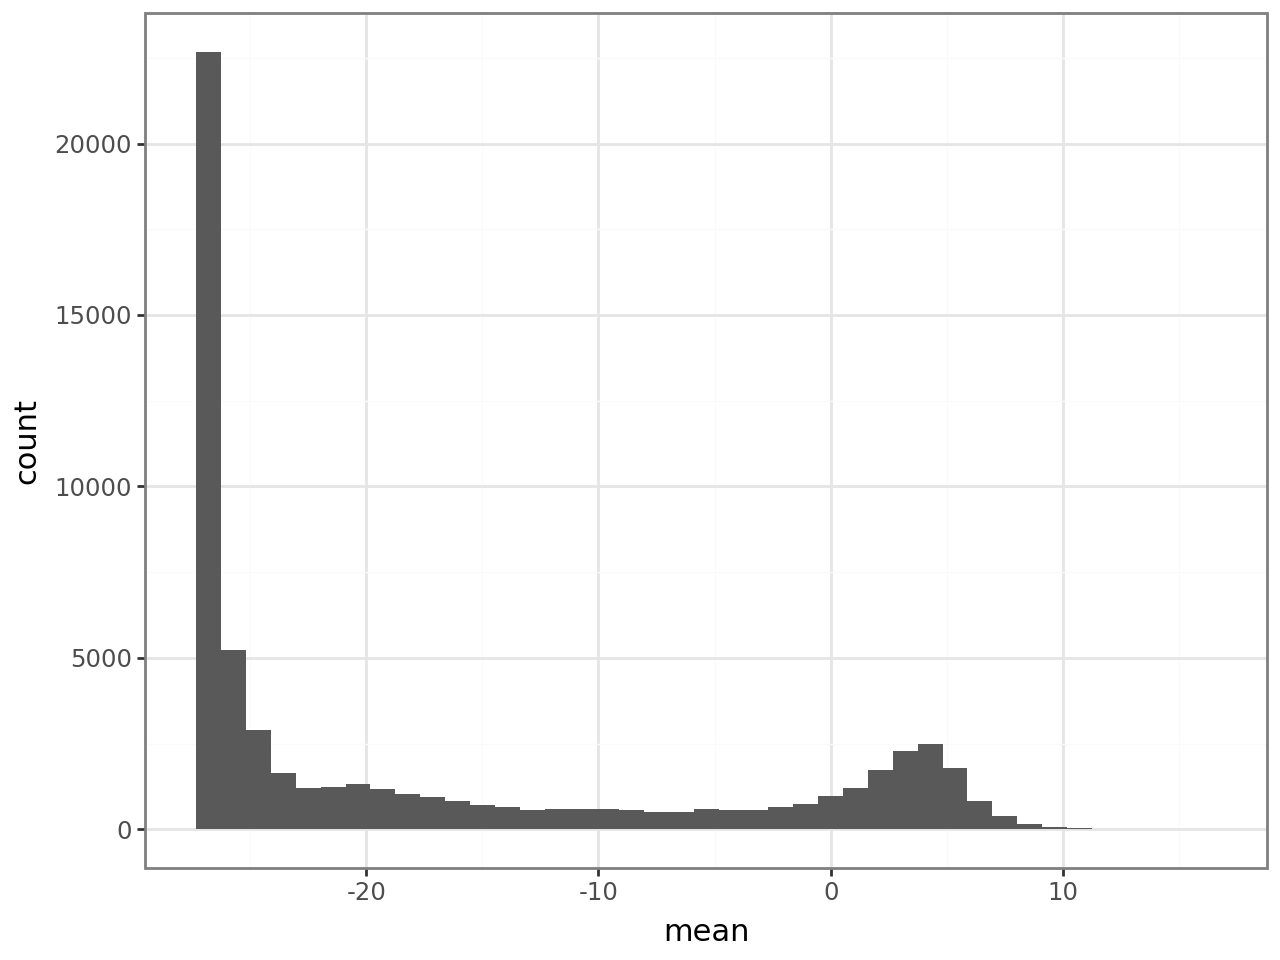

In [17]:
from plotnine import ggplot, aes, theme_bw, geom_histogram

plot = (ggplot(gene_stats) + aes(x="mean") +
        geom_histogram() +
        theme_bw())

plot.show()

In [19]:
high_exp = gene_stats.filter(pl.col("mean") > 0).select("ENSG").to_series().to_list()
high_exp = [i.split(".")[0] for i in high_exp]

In [22]:
print(motive_map.shape)
print(motive_map.filter(pl.col("EnsemblID").is_in(high_exp)).shape)

(4989, 2)
(3495, 2)
